In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Для Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Для метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

print("Все библиотеки успешно импортированы")

Importing plotly failed. Interactive plots will not work.


Все библиотеки успешно импортированы


In [3]:
df_opzh = pd.read_excel('../../общая_ОПЖ (2).xlsx')
df_skr = pd.read_excel('../../общая_СКР (2).xlsx')

In [4]:
# функция для удаления всех видов пробелов
def remove_all_spaces(value):
    if isinstance(value, str):
        # Удаляем все виды пробелов: обычные, неразрывные и т.д.
        cleaned = ''.join(value.split())
        # Пробуем преобразовать к числу
        try:
            # Проверяем, является ли результат числом
            if cleaned.replace('.', '').replace(',', '').isdigit():
                # Заменяем запятую на точку для преобразования в float
                cleaned = cleaned.replace(',', '.')
                return float(cleaned) if '.' in cleaned else int(cleaned)
            else:
                return value
        except (ValueError, AttributeError):
            return value
    return value

# Применяем ко всем столбцам
df_opzh = df_opzh.applymap(remove_all_spaces)
df_skr = df_skr.applymap(remove_all_spaces)

print("\nПосле очистки данных:")
print("Типы данных в df_opzh:")
print(df_opzh.dtypes)
print("\nПервые 5 строк df_opzh:")
print(df_opzh.head())


После очистки данных:
Типы данных в df_opzh:
Регион                                                       object
Год                                                           int64
ОПЖ                                                         float64
Численность населения                                         int64
Число умерших                                                 int64
Общая численность инвалидов                                   int64
Кол-во преступлений                                         float64
Валовой региональный продукт на душу населения (ОКВЭД 2)    float64
Величина прожиточного минимума                              float64
Уровень бедности                                            float64
Средняя ЗП                                                    int64
Численность врачей всех специальностей                        int64
Число больничных организаций на конец отчетного года          int64
Число санаторно-курортных организаций                         int64
Мл

In [5]:
def prepare_data_for_prophet(df, value_col, region_col='Регион', year_col='Год'):
    """Подготовка данных для Prophet — ОСТАВЛЯЕМ РЕГИОН"""
    df_prophet = df.copy()
    
    # Создаем столбец даты
    df_prophet['ds'] = pd.to_datetime(df_prophet[year_col].astype(str) + '-01-01')
    df_prophet['y'] = df_prophet[value_col]
    
    # ВАЖНО: Оставляем 'Регион'! Prophet не использует его, но он нужен для группировки
    # Возвращаем датафрейм с ['Регион', 'ds', 'y'] + исходные колонки (это нормально)
    return df_prophet[['Регион', 'ds', 'y']]

In [6]:
# Функция для стандартизации названий регионов
def standardize_region_names(df):
    """Стандартизация названий регионов"""
    df_clean = df.copy()
    
    # Создаем словарь замен
    replacements = {
        'Ненецкий авт.округ': 'Ненецкий автономный округ',
        'Hенецкий авт.округ': 'Ненецкий автономный округ',  # латинская H
        '  Ненецкий автономный округ': 'Ненецкий автономный округ',
        
        'Ямало-Ненецкий авт.округ': 'Ямало-Ненецкий автономный округ',
        'Ямало-Hенецкий авт.округ': 'Ямало-Ненецкий автономный округ',  # латинская H
        '  Ямало-Ненецкий автономный округ': 'Ямало-Ненецкий автономный округ',
        
        'Ханты-Мансийский авт.округ-Югра': 'Ханты-Мансийский автономный округ - Югра',
        '  Ханты-Мансийский автономный округ - Югра': 'Ханты-Мансийский автономный округ - Югра',
        
        'Республика Татарстан(Татарстан)': 'Республика Татарстан',
        'Чувашская Республика(Чувашия)': 'Чувашская Республика',
        'Республика Северная Осетия- Алания': 'Республика Северная Осетия-Алания',
        
        'Oмская область': 'Омская область',  # латинская O
        'Hижегородская область': 'Нижегородская область',  # латинская H
        
        'г. Севастополь': 'г.Севастополь',
        'г.Москва': 'г.Москва',
        'г.Санкт-Петербург': 'г.Санкт-Петербург',
        
        'Чукотский авт.округ': 'Чукотский автономный округ',
        'Чукотский автономный округ': 'Чукотский автономный округ'
    }
    
    # Применяем замены
    df_clean['Регион'] = df_clean['Регион'].replace(replacements)
    
    # Удаляем лишние пробелы
    df_clean['Регион'] = df_clean['Регион'].str.strip()
    
    return df_clean

# Применяем стандартизацию к обоим датасетам
print("Стандартизация названий регионов...")
df_opzh_clean = standardize_region_names(df_opzh)
df_skr_clean = standardize_region_names(df_skr)

print(f"Уникальных регионов в ОПЖ после очистки: {df_opzh_clean['Регион'].nunique()}")
print(f"Уникальных регионов в СКР после очистки: {df_skr_clean['Регион'].nunique()}")

# Проверяем общие регионы
common_regions = set(df_opzh_clean['Регион']).intersection(set(df_skr_clean['Регион']))
print(f"Общих регионов между датасетами: {len(common_regions)}")

Стандартизация названий регионов...
Уникальных регионов в ОПЖ после очистки: 85
Уникальных регионов в СКР после очистки: 85
Общих регионов между датасетами: 85


In [7]:

# Подготовка данных для ОПЖ
df_opzh_prophet = prepare_data_for_prophet(df_opzh_clean, 'ОПЖ')
df_skr_prophet = prepare_data_for_prophet(df_skr_clean, 'СКР')

print("Данные подготовлены для Prophet")

Данные подготовлены для Prophet


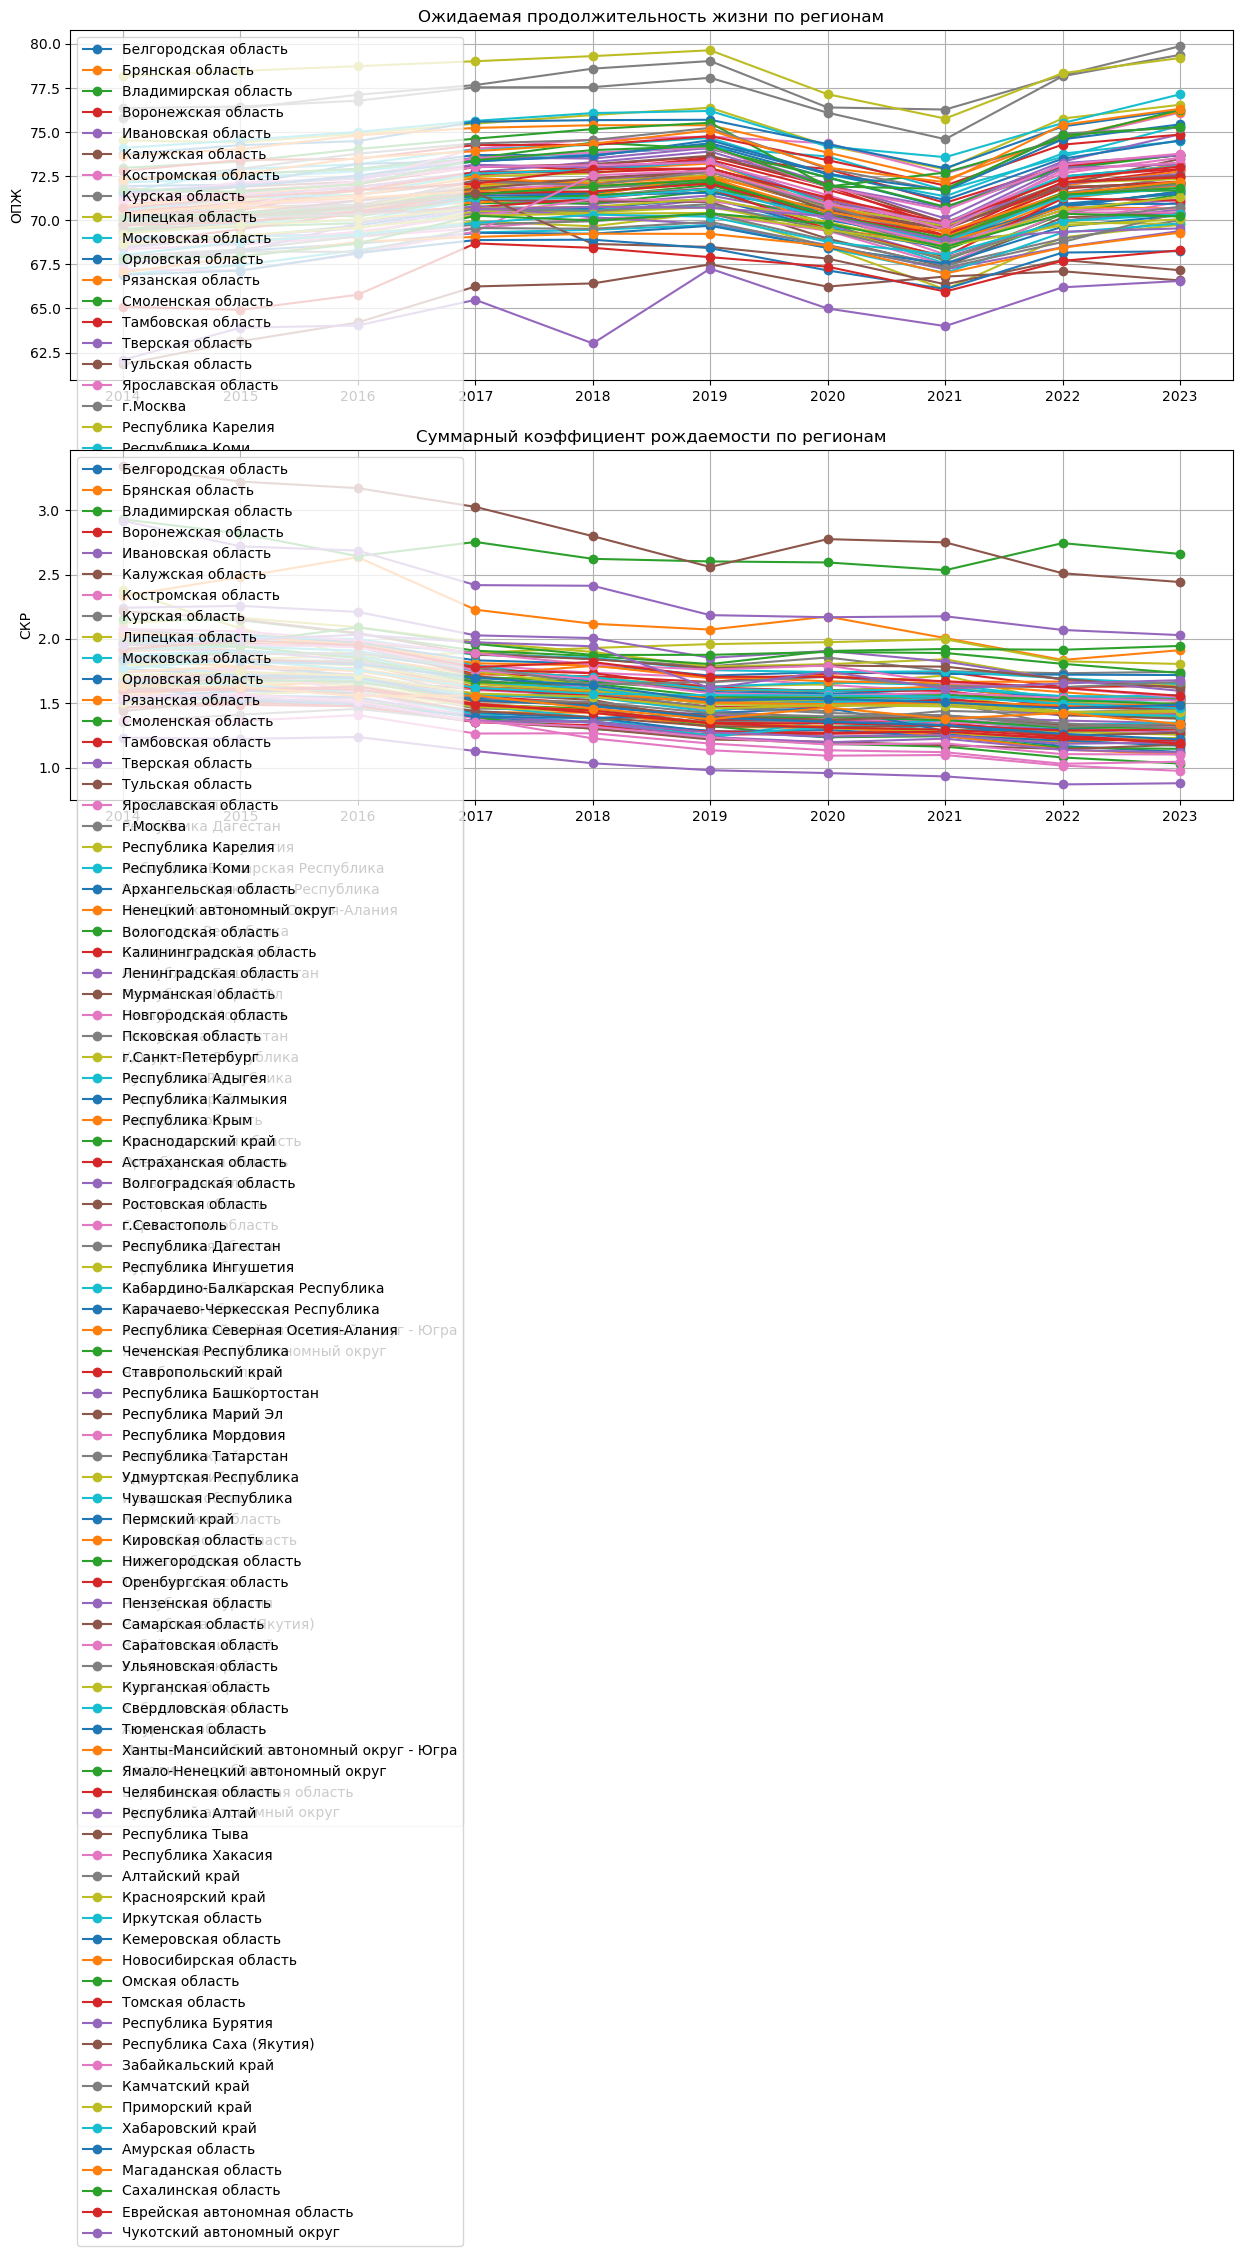

In [8]:

# === Визуализация исходных данных ===
# ЗАМЕНИТЕ эту визуализацию - используем 'Регион' вместо 'region'
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ОПЖ по регионам
regions = df_opzh_prophet['Регион'].unique()  # Покажем только 5 регионов для наглядности
for region in regions:
    region_data = df_opzh_prophet[df_opzh_prophet['Регион'] == region]  # ✅ 'Регион' вместо 'region'
    axes[0].plot(region_data['ds'], region_data['y'], marker='o', label=region)

axes[0].set_title('Ожидаемая продолжительность жизни по регионам')
axes[0].set_ylabel('ОПЖ')
axes[0].legend()
axes[0].grid(True)

# СКР по регионам
for region in regions:
    region_data = df_skr_prophet[df_skr_prophet['Регион'] == region]  # ✅ 'Регион' вместо 'region'
    axes[1].plot(region_data['ds'], region_data['y'], marker='o', label=region)

axes[1].set_title('Суммарный коэффициент рождаемости по регионам')
axes[1].set_ylabel('СКР')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
def train_prophet_models(df, target_col='y', horizon=2):
    regions = df['Регион'].unique()
    models = {}
    forecasts = {}
    metrics = {}
    
    for region in regions:
        print(f"\n--- Обучение для региона: {region} ---")
        region_data = df[df['Регион'] == region].copy().sort_values('ds')
        
        print(f"Доступные годы: {sorted(region_data['ds'].dt.year.unique())}")
        print(f"Значения: {region_data['y'].tolist()}")
        
        if len(region_data) < 5:
            print("Слишком мало данных, пропускаем")
            continue
            
        # Разделение на train/test
        train_data = region_data.iloc[:-2] if len(region_data) >= 5 else region_data.iloc[:-1]
        test_data = region_data.iloc[-2:] if len(region_data) >= 5 else region_data.iloc[-1:]
        
        print(f"Train годы: {sorted(train_data['ds'].dt.year.unique())}")
        print(f"Test годы: {sorted(test_data['ds'].dt.year.unique())}")
        
        try:
            # Подготовка данных для Prophet
            train_for_prophet = train_data[['ds', 'y']].copy()
            
            # Настройка модели для демографических данных
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=0.05,  # Меньше = более плавные изменения
                seasonality_prior_scale=10.0,
                changepoint_range=0.8,  # 80% данных для точек изменения
                interval_width=0.95
            )
            
            model.fit(train_for_prophet)
            
            # Прогноз на будущее
            last_year = region_data['ds'].dt.year.max()
            future_years = [last_year + i for i in range(1, horizon + 1)]
            future_dates = pd.to_datetime([f'{y}-01-01' for y in future_years])
            future_df = pd.DataFrame({'ds': future_dates})
            
            future_forecast = model.predict(future_df)
            
            # Оценка на тестовых данных
            test_forecast = model.predict(test_data[['ds']])
            y_true = test_data['y'].values
            y_pred = test_forecast['yhat'].values
            
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            metrics[region] = {'RMSE': rmse, 'MAE': mae}
            
            print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
            print(f"Факт: {y_true}, Прогноз: {y_pred}")
            
            # Сохраняем модель и прогноз
            models[region] = model
            forecasts[region] = future_forecast
            
        except Exception as e:
            print(f"Ошибка: {e}")
    
    return models, forecasts, metrics

In [12]:
def plot_forecasts(forecasts, df, target_name, region, models=None):
    """Улучшенная визуализация с диагностикой"""
    if region not in forecasts:
        print(f"Нет прогноза для региона: {region}")
        return
        
    # Фактические данные
    fact_data = df[df['Регион'] == region].copy().sort_values('ds')
    fact_data['Год'] = fact_data['ds'].dt.year
    
    # Прогноз
    forecast = forecasts[region].copy()
    forecast['Год'] = forecast['ds'].dt.year
    
    print(f"\n=== АНАЛИЗ {target_name} - {region} ===")
    print("Фактические данные:")
    for _, row in fact_data.iterrows():
        print(f"  {row['Год']}: {row['y']:.2f}")
    
    print("Прогноз на будущее:")
    for _, row in forecast.iterrows():
        print(f"  {row['Год']}: {row['yhat']:.2f}")
    
    # Построение графика
    plt.figure(figsize=(12, 6))
    
    # Фактические данные
    plt.plot(fact_data['Год'], fact_data['y'], 'bo-', 
             markersize=8, linewidth=2, label='Фактические данные')
    
    # Прогноз
    plt.plot(forecast['Год'], forecast['yhat'], 'ro-', 
             markersize=8, linewidth=2, label='Прогноз')
    
    # Доверительный интервал
    plt.fill_between(forecast['Год'],
                    forecast['yhat_lower'],
                    forecast['yhat_upper'],
                    color='red', alpha=0.2, label='Доверительный интервал')
    
    plt.title(f'{target_name} - {region}\n(Синие точки - факт, Красные - прогноз)', fontsize=14)
    plt.xlabel('Год', fontsize=12)
    plt.ylabel(target_name, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

20:28:29 - cmdstanpy - INFO - Chain [1] start processing


=== ПРОВЕРКА ДАННЫХ ===
df_opzh_clean columns: ['Регион', 'Год', 'ОПЖ', 'Численность населения', 'Число умерших', 'Общая численность инвалидов', 'Кол-во преступлений', 'Валовой региональный продукт на душу населения (ОКВЭД 2)', 'Величина прожиточного минимума', 'Уровень бедности', 'Средняя ЗП', 'Численность врачей всех специальностей', 'Число больничных организаций на конец отчетного года', 'Число санаторно-курортных организаций', 'Младенческая смертность коэф', 'Браков', 'Разводов']
df_skr_clean columns: ['Регион', 'Год', 'СКР', 'Численность населения', 'Число родившихся', 'Браков', 'Разводов', 'Введено в действие общей площади жилых домов на 1000 человек населения', 'Кол-во преступлений', 'Уровень безработицы', 'Уровень бедности', 'Величина прожиточного минимума', 'Валовой региональный продукт на душу населения (ОКВЭД 2)', 'Средняя ЗП']
После подготовки:
df_opzh_prophet sample:
                 Регион         ds      y
0  Белгородская область 2023-01-01  73.70
1      Брянская область

20:28:35 - cmdstanpy - INFO - Chain [1] done processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.8503, MAE: 5.7011
Факт: [73.03 73.7 ], Прогноз: [68.64172715 66.68607673]

--- Обучение для региона: Брянская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.37, 70.3, 70.84, 71.16, 71.57, 72.14, 70.48, 68.54, 71.22, 71.98]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:28:41 - cmdstanpy - INFO - Chain [1] done processing
20:28:41 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.9920, MAE: 3.8937
Факт: [71.22 71.98], Прогноз: [68.20678614 67.2058216 ]

--- Обучение для региона: Владимирская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.3, 69.88, 70.36, 71.25, 71.35, 72.0, 70.19, 68.31, 70.8, 71.62]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:28:47 - cmdstanpy - INFO - Chain [1] done processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.7432, MAE: 6.5721
Факт: [70.8  71.62], Прогноз: [65.73697855 63.5387542 ]

--- Обучение для региона: Воронежская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.82, 71.67, 72.08, 73.03, 73.15, 73.61, 71.94, 69.58, 72.45, 72.91]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:28:54 - cmdstanpy - INFO - Chain [1] done processing
20:28:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.0985, MAE: 5.9907
Факт: [72.45 72.91], Прогноз: [67.60097836 65.77759907]

--- Обучение для региона: Ивановская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.7, 70.4, 70.5, 71.16, 70.92, 71.41, 70.18, 68.51, 70.57, 71.18]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:00 - cmdstanpy - INFO - Chain [1] done processing
20:29:01 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.6955, MAE: 5.5694
Факт: [70.57 71.18], Прогноз: [66.19247674 64.41873365]

--- Обучение для региона: Калужская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.1, 70.95, 71.45, 72.18, 72.27, 72.79, 70.92, 69.78, 72.48, 73.08]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:07 - cmdstanpy - INFO - Chain [1] done processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.9741, MAE: 4.8627
Факт: [72.48 73.08], Прогноз: [68.6639802  67.17065361]

--- Обучение для региона: Костромская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.86, 70.13, 70.57, 71.43, 71.42, 71.83, 70.31, 68.06, 69.9, 71.05]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:13 - cmdstanpy - INFO - Chain [1] done processing
20:29:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.5344, MAE: 5.3376
Факт: [69.9  71.05], Прогноз: [66.02537518 64.24945174]

--- Обучение для региона: Курская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.08, 70.77, 70.89, 71.67, 71.84, 72.18, 70.45, 68.51, 71.54, 72.45]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:20 - cmdstanpy - INFO - Chain [1] done processing
20:29:20 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.6450, MAE: 6.4955
Факт: [71.54 72.45], Прогноз: [66.44583826 64.55308584]

--- Обучение для региона: Липецкая область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.63, 71.11, 71.66, 72.5, 72.66, 73.38, 70.68, 68.72, 72.12, 72.44]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.8710, MAE: 7.7204
Факт: [72.12 72.44], Прогноз: [65.93240614 63.18687116]

--- Обучение для региона: Московская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.56, 72.9, 73.18, 74.04, 74.28, 74.67, 72.59, 71.36, 73.78, 74.49]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:32 - cmdstanpy - INFO - Chain [1] done processing
20:29:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.9598, MAE: 5.7988
Факт: [73.78 74.49], Прогноз: [69.35684986 67.31553052]

--- Обучение для региона: Орловская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.85, 70.34, 70.68, 71.56, 71.48, 72.46, 70.02, 68.9, 70.73, 71.65]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:38 - cmdstanpy - INFO - Chain [1] done processing
20:29:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.4675, MAE: 5.2460
Факт: [70.73 71.65], Прогноз: [67.02440664 64.86355173]

--- Обучение для региона: Рязанская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.82, 71.48, 71.89, 72.72, 72.86, 73.22, 71.03, 68.78, 72.14, 73.19]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:45 - cmdstanpy - INFO - Chain [1] done processing
20:29:45 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.7149, MAE: 6.5466
Факт: [72.14 73.19], Прогноз: [67.08760845 65.14920583]

--- Обучение для региона: Смоленская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.35, 69.64, 69.84, 70.97, 70.96, 71.66, 69.84, 67.72, 70.35, 71.47]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:52 - cmdstanpy - INFO - Chain [1] done processing
20:29:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.0530, MAE: 6.8555
Факт: [70.35 71.47], Прогноз: [65.15206356 62.95696584]

--- Обучение для региона: Тамбовская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.07, 71.63, 72.05, 73.14, 72.86, 73.43, 71.74, 69.9, 72.01, 72.87]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:29:59 - cmdstanpy - INFO - Chain [1] done processing
20:29:59 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.0503, MAE: 6.8589
Факт: [72.01 72.87], Прогноз: [66.78264899 64.37958858]

--- Обучение для региона: Тверская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.42, 69.09, 69.22, 70.43, 70.44, 71.2, 69.74, 67.88, 69.94, 70.61]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:06 - cmdstanpy - INFO - Chain [1] done processing
20:30:06 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.9628, MAE: 4.8357
Факт: [69.94 70.61], Прогноз: [66.21986902 64.65865434]

--- Обучение для региона: Тульская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.78, 70.26, 70.8, 71.46, 72.09, 72.58, 70.68, 69.54, 71.86, 72.15]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:13 - cmdstanpy - INFO - Chain [1] done processing
20:30:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.5545, MAE: 4.4599
Факт: [71.86 72.15], Прогноз: [68.32341769 66.76669899]

--- Обучение для региона: Ярославская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.57, 70.89, 71.1, 71.72, 72.09, 72.74, 70.73, 68.82, 71.55, 71.99]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:20 - cmdstanpy - INFO - Chain [1] done processing
20:30:20 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.2554, MAE: 6.1277
Факт: [71.55 71.99], Прогноз: [66.67980595 64.60487013]

--- Обучение для региона: г.Москва ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [76.36, 76.45, 76.78, 77.54, 77.55, 78.08, 76.1, 74.6, 78.17, 79.38]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:26 - cmdstanpy - INFO - Chain [1] done processing
20:30:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.7595, MAE: 7.5763
Факт: [78.17 79.38], Прогноз: [72.26994618 70.12755184]

--- Обучение для региона: Республика Карелия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.04, 68.72, 69.19, 69.94, 69.66, 70.44, 68.49, 66.08, 69.03, 69.75]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:33 - cmdstanpy - INFO - Chain [1] done processing
20:30:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 8.3160, MAE: 8.1370
Факт: [69.03 69.75], Прогноз: [62.60900257 59.89701131]

--- Обучение для региона: Республика Коми ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.85, 69.14, 69.12, 70.69, 70.61, 70.78, 69.7, 67.55, 69.94, 70.43]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:39 - cmdstanpy - INFO - Chain [1] done processing
20:30:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.4809, MAE: 6.3672
Факт: [69.94 70.43], Прогноз: [64.78140559 62.85418761]

--- Обучение для региона: Архангельская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.92, 70.34, 70.34, 71.39, 71.44, 71.56, 70.5, 68.68, 70.93, 71.51]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:46 - cmdstanpy - INFO - Chain [1] done processing
20:30:46 - cmdstanpy - INFO - Chain [1] start processing
20:30:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 5.0498, MAE: 4.9530
Факт: [70.93 71.51], Прогноз: [66.96104367 65.57302911]

--- Обучение для региона: Ненецкий автономный округ ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.14, 70.29, 70.72, 71.0, 71.41, 72.55, 69.48, 68.76, 70.74, 70.67]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.1657, MAE: 4.0909
Факт: [70.74 70.67], Прогноз: [67.43520702 65.79309001]

--- Обучение для региона: Вологодская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.72, 70.39, 70.22, 71.23, 71.4, 71.78, 70.68, 69.06, 71.56, 71.7]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:53 - cmdstanpy - INFO - Chain [1] done processing
20:30:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 2.1456, MAE: 2.1360
Факт: [71.56 71.7 ], Прогноз: [69.62693724 69.36101275]

--- Обучение для региона: Калининградская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.25, 70.56, 71.89, 72.6, 72.89, 73.53, 72.91, 70.99, 73.07, 73.71]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:30:59 - cmdstanpy - INFO - Chain [1] done processing
20:31:00 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.7793, MAE: 5.6738
Факт: [73.07 73.71], Прогноз: [68.49505515 66.9372459 ]

--- Обучение для региона: Ленинградская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.37, 71.36, 71.88, 72.73, 73.3, 73.9, 71.93, 70.7, 73.33, 74.88]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:06 - cmdstanpy - INFO - Chain [1] done processing
20:31:06 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.4168, MAE: 5.1976
Факт: [73.33 74.88], Прогноз: [69.65756498 68.15718639]

--- Обучение для региона: Мурманская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.73, 69.9, 70.52, 71.17, 71.09, 71.04, 68.96, 67.37, 70.16, 70.44]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:13 - cmdstanpy - INFO - Chain [1] done processing
20:31:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.3859, MAE: 6.2678
Факт: [70.16 70.44], Прогноз: [65.11502781 62.94941267]

--- Обучение для региона: Новгородская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.35, 68.63, 69.06, 69.56, 70.1, 70.33, 69.41, 67.48, 70.45, 70.43]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:19 - cmdstanpy - INFO - Chain [1] done processing
20:31:19 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.7209, MAE: 4.6921
Факт: [70.45 70.43], Прогноз: [66.27944682 65.21643867]

--- Обучение для региона: Псковская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.97, 68.35, 69.09, 69.76, 69.95, 70.38, 68.86, 67.44, 68.95, 70.0]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:26 - cmdstanpy - INFO - Chain [1] done processing
20:31:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.0002, MAE: 4.8050
Факт: [68.95 70.  ], Прогноз: [65.52835235 63.81157985]

--- Обучение для региона: г.Санкт-Петербург ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [74.53, 74.42, 74.91, 75.48, 75.97, 76.38, 74.23, 72.89, 75.77, 76.55]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:32 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.6337, MAE: 6.4728
Факт: [75.77 76.55], Прогноз: [70.74940705 68.6250162 ]

--- Обучение для региона: Республика Адыгея ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [72.14, 72.4, 72.79, 73.46, 73.81, 74.13, 73.62, 71.7, 73.6, 75.36]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.7630, MAE: 3.5864
Факт: [73.6  75.36], Прогноз: [71.15259983 70.63450603]

--- Обучение для региона: Республика Калмыкия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.94, 72.02, 73.2, 73.36, 73.63, 74.54, 72.67, 71.15, 73.49, 74.53]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:46 - cmdstanpy - INFO - Chain [1] done processing
20:31:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.1362, MAE: 4.9645
Факт: [73.49 74.53], Прогноз: [69.84243747 68.24858952]

--- Обучение для региона: Республика Крым ---
Доступные годы: [np.int32(2014), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.68, 70.76, 72.02, 72.25, 72.74, 71.23, 69.75, 71.97, 72.76]
Train годы: [np.int32(2014), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:52 - cmdstanpy - INFO - Chain [1] done processing
20:31:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.7472, MAE: 5.5995
Факт: [71.97 72.76], Прогноз: [67.66477464 65.86618056]

--- Обучение для региона: Краснодарский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [72.34, 72.6, 72.92, 73.52, 74.41, 74.05, 72.44, 70.77, 72.92, 73.71]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:31:58 - cmdstanpy - INFO - Chain [1] done processing
20:31:59 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.5808, MAE: 3.4654
Факт: [72.92 73.71], Прогноз: [70.35640112 69.34289051]

--- Обучение для региона: Астраханская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.47, 70.98, 71.7, 72.72, 72.73, 72.95, 71.15, 69.14, 71.8, 72.2]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:05 - cmdstanpy - INFO - Chain [1] done processing
20:32:05 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.3075, MAE: 6.1876
Факт: [71.8 72.2], Прогноз: [66.83636886 64.78850675]

--- Обучение для региона: Волгоградская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.63, 72.0, 72.52, 73.56, 73.5, 74.11, 72.08, 70.11, 73.24, 73.69]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:12 - cmdstanpy - INFO - Chain [1] done processing
20:32:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.9606, MAE: 7.8140
Факт: [73.24 73.69], Прогноз: [66.94697435 64.35509065]

--- Обучение для региона: Ростовская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.3, 71.9, 72.19, 73.01, 73.18, 73.66, 72.05, 69.87, 72.0, 73.48]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:19 - cmdstanpy - INFO - Chain [1] done processing
20:32:19 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.2537, MAE: 4.0503
Факт: [72.   73.48], Прогноз: [69.24942501 68.13000278]

--- Обучение для региона: г.Севастополь ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.94, 70.76, 72.23, 74.07, 74.58, 74.75, 74.36, 72.65, 74.57, 76.11]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:25 - cmdstanpy - INFO - Chain [1] done processing
20:32:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.8100, MAE: 5.6295
Факт: [74.57 76.11], Прогноз: [70.37757689 69.04348096]

--- Обучение для региона: Республика Дагестан ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [75.79, 76.34, 77.12, 77.67, 78.6, 79.03, 76.4, 76.28, 78.22, 79.87]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:32 - cmdstanpy - INFO - Chain [1] done processing
20:32:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.4142, MAE: 3.1050
Факт: [78.22 79.87], Прогноз: [76.53489749 75.34516379]

--- Обучение для региона: Республика Ингушетия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [78.18, 78.47, 78.74, 79.02, 79.31, 79.64, 77.15, 75.77, 78.34, 79.2]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:39 - cmdstanpy - INFO - Chain [1] done processing
20:32:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.6754, MAE: 6.4752
Факт: [78.34 79.2 ], Прогноз: [73.48758915 71.10201571]

--- Обучение для региона: Кабардино-Балкарская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [74.1, 74.54, 75.01, 75.64, 76.08, 76.2, 74.19, 73.58, 75.51, 77.14]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:45 - cmdstanpy - INFO - Chain [1] done processing
20:32:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.1226, MAE: 4.8578
Факт: [75.51 77.14], Прогноз: [72.2780818  70.65635409]

--- Обучение для региона: Карачаево-Черкесская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [73.75, 74.26, 74.49, 75.59, 75.68, 75.7, 74.32, 72.95, 75.32, 76.25]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:52 - cmdstanpy - INFO - Chain [1] done processing
20:32:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.9720, MAE: 5.8199
Факт: [75.32 76.25], Прогноз: [70.83957016 69.09065564]

--- Обучение для региона: Республика Северная Осетия-Алания ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [73.67, 74.03, 74.82, 75.24, 75.39, 75.39, 73.84, 72.3, 74.7, 76.16]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.6767, MAE: 5.4718
Факт: [74.7  76.16], Прогноз: [70.73968967 69.17680494]

--- Обучение для региона: Чеченская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [72.97, 73.33, 74.04, 74.63, 75.17, 75.53, 71.91, 72.71, 74.61, 76.26]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.4197, MAE: 4.1298
Факт: [74.61 76.26], Прогноз: [72.05459274 70.55589458]

--- Обучение для региона: Ставропольский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [72.8, 73.42, 73.48, 74.27, 74.28, 74.77, 73.41, 71.97, 74.29, 74.86]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:06 - cmdstanpy - INFO - Chain [1] done processing
20:33:06 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.8486, MAE: 3.7674
Факт: [74.29 74.86], Прогноз: [71.30886811 70.30628742]

--- Обучение для региона: Республика Башкортостан ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.85, 70.19, 71.13, 71.87, 72.23, 72.82, 70.62, 69.8, 72.98, 73.17]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:12 - cmdstanpy - INFO - Chain [1] done processing
20:33:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.3886, MAE: 5.3058
Факт: [72.98 73.17], Прогноз: [68.61472263 66.92359428]

--- Обучение для региона: Республика Марий Эл ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.45, 69.84, 70.79, 72.27, 72.03, 72.95, 71.15, 69.59, 71.9, 72.04]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:18 - cmdstanpy - INFO - Chain [1] done processing
20:33:19 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.1311, MAE: 6.0213
Факт: [71.9  72.04], Прогноз: [67.0338032  64.86358647]

--- Обучение для региона: Республика Мордовия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.44, 72.14, 72.37, 73.53, 73.83, 74.14, 71.88, 70.57, 73.16, 73.78]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:25 - cmdstanpy - INFO - Chain [1] done processing
20:33:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.6107, MAE: 5.4641
Факт: [73.16 73.78], Прогноз: [68.97012716 67.04174617]

--- Обучение для региона: Республика Татарстан ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [72.26, 72.92, 73.78, 74.36, 74.55, 75.24, 72.92, 71.66, 74.92, 75.25]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:32 - cmdstanpy - INFO - Chain [1] done processing
20:33:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.1880, MAE: 6.0780
Факт: [74.92 75.25], Прогноз: [70.00313975 68.01079446]

--- Обучение для региона: Удмуртская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.81, 70.35, 70.75, 71.91, 72.23, 72.55, 70.77, 69.68, 72.13, 72.34]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:38 - cmdstanpy - INFO - Chain [1] done processing
20:33:38 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.3799, MAE: 5.2849
Факт: [72.13 72.34], Прогноз: [67.8518929  66.04836343]

--- Обучение для региона: Чувашская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.58, 71.29, 71.45, 72.65, 72.86, 73.34, 70.93, 69.87, 72.49, 73.07]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.7766, MAE: 6.6059
Факт: [72.49 73.07], Прогноз: [67.39575082 64.95251867]

--- Обучение для региона: Пермский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.01, 69.06, 69.7, 70.74, 70.67, 71.25, 69.52, 68.45, 70.9, 70.94]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.3857, MAE: 3.3419
Факт: [70.9  70.94], Прогноз: [68.10094377 67.05526582]

--- Обучение для региона: Кировская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.39, 70.88, 71.43, 72.4, 72.08, 72.48, 70.87, 69.08, 71.31, 71.99]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:33:58 - cmdstanpy - INFO - Chain [1] done processing
20:33:58 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.9240, MAE: 6.7603
Факт: [71.31 71.99], Прогноз: [66.04648561 63.73289103]

--- Обучение для региона: Нижегородская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.49, 70.11, 70.68, 71.79, 71.59, 72.19, 70.21, 68.81, 71.49, 72.1]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:05 - cmdstanpy - INFO - Chain [1] done processing
20:34:05 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.0376, MAE: 6.8803
Факт: [71.49 72.1 ], Прогноз: [66.08920851 63.74018619]

--- Обучение для региона: Оренбургская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.61, 69.5, 70.41, 70.74, 71.24, 71.81, 69.49, 67.96, 71.24, 71.12]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:11 - cmdstanpy - INFO - Chain [1] done processing
20:34:11 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.6472, MAE: 4.5972
Факт: [71.24 71.12], Прогноз: [67.32280395 65.84286716]

--- Обучение для региона: Пензенская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.55, 72.0, 72.38, 73.15, 73.0, 73.35, 71.12, 69.77, 72.07, 72.63]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:18 - cmdstanpy - INFO - Chain [1] done processing
20:34:18 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.6311, MAE: 6.4592
Факт: [72.07 72.63], Прогноз: [67.11059102 64.67096697]

--- Обучение для региона: Самарская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.67, 70.4, 71.13, 71.79, 72.38, 72.84, 70.58, 69.48, 72.14, 72.53]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:24 - cmdstanpy - INFO - Chain [1] done processing
20:34:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.0658, MAE: 4.9519
Факт: [72.14 72.53], Прогноз: [68.25617703 66.50998283]

--- Обучение для региона: Саратовская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.03, 71.5, 72.2, 73.02, 73.13, 73.28, 71.43, 69.46, 72.85, 73.27]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:31 - cmdstanpy - INFO - Chain [1] done processing
20:34:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.9509, MAE: 6.8413
Факт: [72.85 73.27], Прогноз: [67.23847932 65.19897497]

--- Обучение для региона: Ульяновская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.3, 70.36, 70.85, 72.19, 72.0, 72.76, 70.79, 68.87, 71.34, 72.04]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:37 - cmdstanpy - INFO - Chain [1] done processing
20:34:38 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.6759, MAE: 7.4906
Факт: [71.34 72.04], Прогноз: [65.5259588  62.87283722]

--- Обучение для региона: Курганская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.62, 68.85, 69.2, 70.52, 70.46, 70.75, 69.52, 67.82, 69.88, 69.79]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:44 - cmdstanpy - INFO - Chain [1] done processing
20:34:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.7876, MAE: 4.7296
Факт: [69.88 69.79], Прогноз: [65.89354794 64.31729517]

--- Обучение для региона: Свердловская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.75, 69.82, 70.01, 71.21, 71.27, 71.79, 70.14, 68.79, 71.31, 71.84]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:51 - cmdstanpy - INFO - Chain [1] done processing
20:34:51 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.4200, MAE: 6.2882
Факт: [71.31 71.84], Прогноз: [66.31609205 64.25755075]

--- Обучение для региона: Тюменская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.61, 71.91, 72.53, 73.34, 73.68, 74.37, 72.63, 71.69, 74.59, 75.44]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:34:57 - cmdstanpy - INFO - Chain [1] done processing
20:34:58 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.1373, MAE: 5.9966
Факт: [74.59 75.44], Прогноз: [69.90027713 68.13654254]

--- Обучение для региона: Ханты-Мансийский автономный округ - Югра ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [72.29, 72.62, 73.54, 73.92, 74.34, 75.11, 72.99, 72.16, 75.41, 76.32]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:04 - cmdstanpy - INFO - Chain [1] done processing
20:35:04 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 6.0249, MAE: 5.8795
Факт: [75.41 76.32], Прогноз: [70.84636717 69.12464842]

--- Обучение для региона: Ямало-Ненецкий автономный округ ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [71.77, 71.61, 72.05, 73.41, 73.98, 74.21, 71.92, 71.78, 74.82, 75.3]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:10 - cmdstanpy - INFO - Chain [1] done processing
20:35:11 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.6617, MAE: 7.5044
Факт: [74.82 75.3 ], Прогноз: [68.86005337 66.25105046]

--- Обучение для региона: Челябинская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.71, 69.9, 70.49, 71.52, 71.64, 72.08, 70.29, 69.17, 72.16, 72.43]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:17 - cmdstanpy - INFO - Chain [1] done processing
20:35:17 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.8465, MAE: 4.7753
Факт: [72.16 72.43], Прогноз: [68.21188706 66.82742695]

--- Обучение для региона: Республика Алтай ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.56, 68.19, 69.84, 70.82, 70.17, 69.78, 68.6, 67.22, 68.47, 69.39]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:23 - cmdstanpy - INFO - Chain [1] done processing
20:35:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 5.9225, MAE: 5.7297
Факт: [68.47 69.39], Прогноз: [64.2392648  62.16135466]

--- Обучение для региона: Республика Тыва ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [61.83, 63.14, 64.21, 66.25, 66.42, 67.5, 66.24, 66.81, 67.11, 66.59]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:30 - cmdstanpy - INFO - Chain [1] done processing
20:35:30 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 2.0315, MAE: 1.9952
Факт: [67.11 66.59], Прогноз: [65.49730901 64.21230815]

--- Обучение для региона: Республика Хакасия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.85, 68.72, 69.36, 70.26, 71.2, 71.1, 70.15, 68.62, 70.57, 70.68]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:37 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 2.5066, MAE: 2.4836
Факт: [70.57 70.68], Прогноз: [68.42529741 67.85752356]

--- Обучение для региона: Алтайский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.77, 70.13, 70.35, 70.62, 70.53, 70.92, 69.45, 67.79, 69.96, 70.77]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:42 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.5633, MAE: 4.4357
Факт: [69.96 70.77], Прогноз: [66.59579825 65.26281898]

--- Обучение для региона: Красноярский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.25, 69.72, 70.05, 70.66, 70.77, 71.23, 69.9, 68.45, 70.58, 71.32]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:48 - cmdstanpy - INFO - Chain [1] done processing
20:35:48 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.3378, MAE: 4.2248
Факт: [70.58 71.32], Прогноз: [67.33873048 66.11169276]

--- Обучение для региона: Иркутская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [66.94, 67.46, 68.31, 69.31, 69.46, 69.73, 68.44, 67.01, 69.31, 69.82]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:35:54 - cmdstanpy - INFO - Chain [1] done processing
20:35:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.9427, MAE: 4.8466
Факт: [69.31 69.82], Прогноз: [65.43314723 64.00364779]

--- Обучение для региона: Кемеровская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.77, 68.27, 68.67, 69.29, 69.24, 69.69, 68.44, 67.54, 69.64, 70.29]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:00 - cmdstanpy - INFO - Chain [1] done processing
20:36:00 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.8848, MAE: 4.7719
Факт: [69.64 70.29], Прогноз: [65.91237861 64.47387401]

--- Обучение для региона: Новосибирская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.33, 70.91, 71.27, 71.65, 71.93, 72.37, 70.47, 69.35, 71.49, 72.2]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:06 - cmdstanpy - INFO - Chain [1] done processing
20:36:06 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.5799, MAE: 4.4408
Факт: [71.49 72.2 ], Прогноз: [68.16939902 66.63894371]

--- Обучение для региона: Омская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.11, 70.39, 70.76, 71.46, 71.93, 72.29, 70.28, 68.98, 71.45, 71.83]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:13 - cmdstanpy - INFO - Chain [1] done processing
20:36:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.3943, MAE: 4.2971
Факт: [71.45 71.83], Прогноз: [68.07212257 66.61367351]

--- Обучение для региона: Томская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [70.7, 71.29, 71.71, 72.08, 72.91, 72.93, 71.29, 69.86, 72.33, 73.05]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:19 - cmdstanpy - INFO - Chain [1] done processing
20:36:19 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.4366, MAE: 4.3255
Факт: [72.33 73.05], Прогноз: [68.99101114 67.73793102]

--- Обучение для региона: Республика Бурятия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.49, 69.1, 69.55, 70.63, 70.76, 70.71, 70.24, 68.87, 69.35, 69.54]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:25 - cmdstanpy - INFO - Chain [1] done processing
20:36:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 1.2103, MAE: 1.1702
Факт: [69.35 69.54], Прогноз: [68.48888555 68.06075598]

--- Обучение для региона: Республика Саха (Якутия) ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [69.76, 70.23, 70.75, 71.56, 68.66, 68.49, 67.83, 66.37, 67.75, 67.17]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:32 - cmdstanpy - INFO - Chain [1] done processing
20:36:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 7.5398, MAE: 7.4568
Факт: [67.75 67.17], Прогноз: [61.40832101 58.59798465]

--- Обучение для региона: Забайкальский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.23, 67.15, 68.1, 69.36, 72.55, 72.82, 70.92, 69.82, 72.67, 73.55]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:39 - cmdstanpy - INFO - Chain [1] done processing
20:36:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 2.4485, MAE: 2.3645
Факт: [72.67 73.55], Прогноз: [70.9410463  70.54987233]

--- Обучение для региона: Камчатский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.82, 68.23, 68.21, 69.56, 69.52, 69.91, 68.56, 67.3, 68.77, 70.43]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:45 - cmdstanpy - INFO - Chain [1] done processing
20:36:45 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.9462, MAE: 4.6861
Факт: [68.77 70.43], Прогноз: [65.66648956 64.161232  ]

--- Обучение для региона: Приморский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.67, 69.14, 69.59, 70.27, 70.38, 70.42, 69.47, 68.53, 69.71, 70.06]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:51 - cmdstanpy - INFO - Chain [1] done processing
20:36:51 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.3773, MAE: 3.2924
Факт: [69.71 70.06], Прогноз: [67.17023774 66.0149951 ]

--- Обучение для региона: Хабаровский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [68.03, 68.78, 69.2, 69.85, 70.32, 70.21, 68.78, 68.05, 69.96, 70.33]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:36:57 - cmdstanpy - INFO - Chain [1] done processing
20:36:57 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.5321, MAE: 3.4527
Факт: [69.96 70.33], Прогноз: [67.25213579 66.13247829]

--- Обучение для региона: Амурская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [66.91, 67.15, 68.14, 68.88, 68.9, 68.42, 67.16, 66.1, 68.17, 68.25]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:03 - cmdstanpy - INFO - Chain [1] done processing
20:37:03 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.6607, MAE: 3.6124
Факт: [68.17 68.25], Прогноз: [65.15019407 64.04496403]

--- Обучение для региона: Магаданская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.05, 67.93, 68.78, 69.06, 69.24, 69.23, 68.56, 66.98, 68.45, 69.3]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:09 - cmdstanpy - INFO - Chain [1] done processing
20:37:09 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 3.1350, MAE: 3.0345
Факт: [68.45 69.3 ], Прогноз: [66.20322966 65.47785569]

--- Обучение для региона: Сахалинская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [67.85, 67.95, 68.69, 70.26, 69.99, 70.39, 69.81, 68.49, 70.37, 70.22]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:15 - cmdstanpy - INFO - Chain [1] done processing
20:37:15 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 4.3560, MAE: 4.3220
Факт: [70.37 70.22], Прогноз: [66.59110333 65.3548602 ]

--- Обучение для региона: Еврейская автономная область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [65.1, 64.92, 65.78, 68.69, 68.44, 67.91, 67.37, 65.96, 67.7, 68.3]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:21 - cmdstanpy - INFO - Chain [1] done processing
20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 5.7151, MAE: 5.6040
Факт: [67.7 68.3], Прогноз: [63.21736208 61.57454094]

--- Обучение для региона: Чукотский автономный округ ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [62.09, 63.91, 64.04, 65.49, 63.02, 67.26, 65.0, 64.0, 66.2, 66.56]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.3618, MAE: 0.3354
Факт: [66.2  66.56], Прогноз: [65.72898106 66.36013867]

--- Обучение для региона: Белгородская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.544, 1.561, 1.547, 1.389, 1.358, 1.287, 1.237, 1.266, 1.169, 1.123]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:22 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0217, MAE: 0.0217
Факт: [1.169 1.123], Прогноз: [1.14793175 1.10060884]

--- Обучение для региона: Брянская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.554, 1.646, 1.608, 1.431, 1.428, 1.319, 1.307, 1.276, 1.196, 1.19]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:22 - cmdstanpy - INFO - Chain [1] done processing
20:37:22 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0269, MAE: 0.0229
Факт: [1.196 1.19 ], Прогноз: [1.18732425 1.15295487]

--- Обучение для региона: Владимирская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.625, 1.706, 1.683, 1.491, 1.459, 1.324, 1.237, 1.245, 1.156, 1.147]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:22 - cmdstanpy - INFO - Chain [1] done processing
20:37:22 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0598, MAE: 0.0533
Факт: [1.156 1.147], Прогноз: [1.12978474 1.06657991]

--- Обучение для региона: Воронежская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.466, 1.511, 1.477, 1.357, 1.33, 1.257, 1.264, 1.275, 1.232, 1.222]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:22 - cmdstanpy - INFO - Chain [1] done processing
20:37:23 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0711, MAE: 0.0702
Факт: [1.232 1.222], Прогноз: [1.17348286 1.14019199]

--- Обучение для региона: Ивановская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.604, 1.678, 1.661, 1.541, 1.496, 1.374, 1.354, 1.397, 1.367, 1.346]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1029, MAE: 0.1019
Факт: [1.367 1.346], Прогноз: [1.27975174 1.22953864]

--- Обучение для региона: Калужская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.648, 1.78, 1.721, 1.572, 1.527, 1.359, 1.397, 1.356, 1.336, 1.339]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:23 - cmdstanpy - INFO - Chain [1] done processing
20:37:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1157, MAE: 0.1129
Факт: [1.336 1.339], Прогноз: [1.24842888 1.20078853]

--- Обучение для региона: Костромская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.901, 1.942, 1.958, 1.796, 1.737, 1.703, 1.644, 1.59, 1.523, 1.552]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:23 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0638, MAE: 0.0540
Факт: [1.523 1.552], Прогноз: [1.50300171 1.46395778]

--- Обучение для региона: Курская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.689, 1.707, 1.637, 1.46, 1.447, 1.351, 1.372, 1.369, 1.29, 1.262]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:24 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0659, MAE: 0.0653
Факт: [1.29  1.262], Прогноз: [1.23362888 1.18785879]

--- Обучение для региона: Липецкая область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.628, 1.663, 1.642, 1.494, 1.442, 1.338, 1.324, 1.278, 1.203, 1.233]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0805, MAE: 0.0700
Факт: [1.203 1.233], Прогноз: [1.17292712 1.12315755]

--- Обучение для региона: Московская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.511, 1.569, 1.604, 1.481, 1.391, 1.233, 1.365, 1.286, 1.329, 1.352]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1767, MAE: 0.1745
Факт: [1.329 1.352], Прогноз: [1.18250018 1.14955948]

--- Обучение для региона: Орловская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.546, 1.596, 1.586, 1.423, 1.389, 1.279, 1.293, 1.248, 1.212, 1.171]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0647, MAE: 0.0646
Факт: [1.212 1.171], Прогноз: [1.14633095 1.10738107]

--- Обучение для региона: Рязанская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.578, 1.622, 1.686, 1.497, 1.443, 1.345, 1.32, 1.248, 1.142, 1.104]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0290, MAE: 0.0290
Факт: [1.142 1.104], Прогноз: [1.169782 1.134213]

--- Обучение для региона: Смоленская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.532, 1.528, 1.519, 1.387, 1.303, 1.234, 1.186, 1.164, 1.08, 1.033]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0411, MAE: 0.0407
Факт: [1.08  1.033], Прогноз: [1.04504922 0.98655874]

--- Обучение для региона: Тамбовская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.473, 1.489, 1.478, 1.355, 1.315, 1.283, 1.272, 1.281, 1.223, 1.207]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0467, MAE: 0.0462
Факт: [1.223 1.207], Прогноз: [1.18323079 1.15430924]

--- Обучение для региона: Тверская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.654, 1.688, 1.702, 1.558, 1.473, 1.411, 1.376, 1.332, 1.296, 1.278]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0808, MAE: 0.0797
Факт: [1.296 1.278], Прогноз: [1.22974101 1.1849147 ]

--- Обучение для региона: Тульская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.44, 1.533, 1.507, 1.361, 1.304, 1.22, 1.202, 1.175, 1.145, 1.179]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1055, MAE: 0.0991
Факт: [1.145 1.179], Прогноз: [1.08205666 1.04377165]

--- Обучение для региона: Ярославская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.649, 1.708, 1.726, 1.546, 1.484, 1.395, 1.388, 1.382, 1.311, 1.316]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0799, MAE: 0.0765
Факт: [1.311 1.316], Прогноз: [1.25758025 1.21639007]

--- Обучение для региона: г.Москва ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.357, 1.413, 1.457, 1.363, 1.365, 1.43, 1.363, 1.442, 1.419, 1.424]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0095, MAE: 0.0088
Факт: [1.419 1.424], Прогноз: [1.40664208 1.41877061]

--- Обучение для региона: Республика Карелия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.794, 1.842, 1.87, 1.694, 1.698, 1.631, 1.648, 1.716, 1.505, 1.534]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0689, MAE: 0.0646
Факт: [1.505 1.534], Прогноз: [1.59343683 1.57481357]

--- Обучение для региона: Республика Коми ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.013, 2.003, 1.98, 1.798, 1.668, 1.63, 1.662, 1.644, 1.544, 1.564]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0109, MAE: 0.0108
Факт: [1.544 1.564], Прогноз: [1.55577454 1.55411358]

--- Обучение для региона: Архангельская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.86, 1.886, 1.887, 1.754, 1.679, 1.608, 1.577, 1.57, 1.493, 1.459]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:29 - cmdstanpy - INFO - Chain [1] done processing
20:37:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0506, MAE: 0.0500
Факт: [1.493 1.459], Прогноз: [1.45055686 1.40138224]

--- Обучение для региона: Ненецкий автономный округ ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.332, 2.482, 2.635, 2.227, 2.118, 2.073, 2.174, 2.007, 1.837, 1.913]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:29 - cmdstanpy - INFO - Chain [1] done processing
20:37:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0344, MAE: 0.0342
Факт: [1.837 1.913], Прогноз: [1.86713648 1.87476501]

--- Обучение для региона: Вологодская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.843, 1.905, 1.877, 1.682, 1.6, 1.512, 1.514, 1.511, 1.413, 1.391]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:30 - cmdstanpy - INFO - Chain [1] done processing
20:37:30 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0759, MAE: 0.0744
Факт: [1.413 1.391], Прогноз: [1.35379095 1.30141644]

--- Обучение для региона: Калининградская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.694, 1.738, 1.72, 1.556, 1.499, 1.375, 1.38, 1.351, 1.257, 1.183]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:30 - cmdstanpy - INFO - Chain [1] done processing
20:37:30 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0258, MAE: 0.0237
Факт: [1.257 1.183], Прогноз: [1.22303417 1.16950894]

--- Обучение для региона: Ленинградская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.234, 1.224, 1.239, 1.13, 1.035, 0.981, 0.959, 0.933, 0.871, 0.88]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:30 - cmdstanpy - INFO - Chain [1] done processing
20:37:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0833, MAE: 0.0782
Факт: [0.871 0.88 ], Прогноз: [0.82168954 0.7729661 ]

--- Обучение для региона: Мурманская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.665, 1.738, 1.685, 1.609, 1.572, 1.506, 1.543, 1.504, 1.47, 1.451]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:31 - cmdstanpy - INFO - Chain [1] done processing
20:37:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0364, MAE: 0.0363
Факт: [1.47  1.451], Прогноз: [1.43545009 1.41293146]

--- Обучение для региона: Новгородская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.741, 1.768, 1.768, 1.604, 1.561, 1.443, 1.383, 1.354, 1.316, 1.257]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:31 - cmdstanpy - INFO - Chain [1] done processing
20:37:31 - cmdstanpy - INFO - Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0634, MAE: 0.0634
Факт: [1.316 1.257], Прогноз: [1.25219711 1.1940036 ]

--- Обучение для региона: Псковская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.676, 1.72, 1.775, 1.555, 1.566, 1.474, 1.44, 1.508, 1.332, 1.305]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0500, MAE: 0.0499
Факт: [1.332 1.305], Прогноз: [1.38367315 1.35320222]

--- Обучение для региона: г.Санкт-Петербург ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.504, 1.568, 1.608, 1.473, 1.432, 1.35, 1.308, 1.293, 1.278, 1.257]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:32 - cmdstanpy - INFO - Chain [1] done processing
20:37:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0581, MAE: 0.0579
Факт: [1.278 1.257], Прогноз: [1.225397   1.19387272]

--- Обучение для региона: Республика Адыгея ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.666, 1.643, 1.584, 1.415, 1.35, 1.253, 1.314, 1.371, 1.31, 1.346]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:32 - cmdstanpy - INFO - Chain [1] done processing
20:37:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1848, MAE: 0.1785
Факт: [1.31  1.346], Прогноз: [1.17905221 1.11990203]

--- Обучение для региона: Республика Калмыкия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.844, 1.822, 1.701, 1.538, 1.6, 1.537, 1.545, 1.535, 1.432, 1.443]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:32 - cmdstanpy - INFO - Chain [1] done processing
20:37:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0273, MAE: 0.0218
Факт: [1.432 1.443], Прогноз: [1.43736494 1.40476121]

--- Обучение для региона: Республика Крым ---
Доступные годы: [np.int32(2014), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.828, 1.75, 1.614, 1.603, 1.546, 1.552, 1.529, 1.436, 1.419]
Train годы: [np.int32(2014), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1386, MAE: 0.1371
Факт: [1.436 1.419], Прогноз: [1.55294004 1.57624576]

--- Обучение для региона: Краснодарский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.8, 1.834, 1.822, 1.707, 1.663, 1.608, 1.602, 1.624, 1.521, 1.532]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:33 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0363, MAE: 0.0285
Факт: [1.521 1.532], Прогноз: [1.51495298 1.4810023 ]

--- Обучение для региона: Астраханская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.968, 1.97, 1.938, 1.727, 1.71, 1.666, 1.731, 1.745, 1.627, 1.635]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0524, MAE: 0.0499
Факт: [1.627 1.635], Прогноз: [1.59338838 1.56889887]

--- Обучение для региона: Волгоградская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.546, 1.558, 1.537, 1.404, 1.349, 1.239, 1.198, 1.226, 1.139, 1.119]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0696, MAE: 0.0662
Факт: [1.139 1.119], Прогноз: [1.09429821 1.03124106]

--- Обучение для региона: Ростовская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.592, 1.611, 1.576, 1.44, 1.393, 1.323, 1.317, 1.324, 1.249, 1.272]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:34 - cmdstanpy - INFO - Chain [1] done processing
20:37:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0879, MAE: 0.0811
Факт: [1.249 1.272], Прогноз: [1.20178842 1.15707962]

--- Обучение для региона: г.Севастополь ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.698, 1.757, 1.586, 1.38, 1.228, 1.136, 1.094, 1.099, 1.017, 0.976]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:34 - cmdstanpy - INFO - Chain [1] done processing
20:37:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1753, MAE: 0.1727
Факт: [1.017 0.976], Прогноз: [0.87446958 0.77311735]

--- Обучение для региона: Республика Дагестан ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.073, 2.015, 1.967, 1.895, 1.843, 1.788, 1.856, 1.75, 1.734, 1.745]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:34 - cmdstanpy - INFO - Chain [1] done processing
20:37:35 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0449, MAE: 0.0432
Факт: [1.734 1.745], Прогноз: [1.70325889 1.68936751]

--- Обучение для региона: Республика Ингушетия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.379, 2.082, 1.864, 1.893, 1.93, 1.96, 1.975, 1.998, 1.827, 1.806]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:35 - cmdstanpy - INFO - Chain [1] done processing
20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:35 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0404, MAE: 0.0350
Факт: [1.827 1.806], Прогноз: [1.88226603 1.82065273]

--- Обучение для региона: Кабардино-Балкарская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.809, 1.722, 1.682, 1.561, 1.548, 1.436, 1.541, 1.55, 1.515, 1.526]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:35 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1389, MAE: 0.1361
Факт: [1.515 1.526], Прогноз: [1.40663974 1.36216479]

--- Обучение для региона: Карачаево-Черкесская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.639, 1.523, 1.493, 1.397, 1.385, 1.423, 1.467, 1.286, 1.3, 1.34]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:35 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0367, MAE: 0.0301
Факт: [1.3  1.34], Прогноз: [1.29099671 1.28888848]

--- Обучение для региона: Республика Северная Осетия-Алания ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.99, 1.907, 1.864, 1.722, 1.791, 1.71, 1.671, 1.655, 1.587, 1.52]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0639, MAE: 0.0607
Факт: [1.587 1.52 ], Прогноз: [1.6277423 1.6006846]

--- Обучение для региона: Чеченская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.929, 2.818, 2.643, 2.753, 2.622, 2.602, 2.594, 2.534, 2.744, 2.66]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.2561, MAE: 0.2560
Факт: [2.744 2.66 ], Прогноз: [2.48247916 2.40950306]

--- Обучение для региона: Ставропольский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.588, 1.607, 1.63, 1.485, 1.445, 1.348, 1.345, 1.328, 1.289, 1.297]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:37 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0927, MAE: 0.0895
Факт: [1.289 1.297], Прогноз: [1.2235778  1.18346967]

--- Обучение для региона: Республика Башкортостан ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.923, 1.91, 1.831, 1.672, 1.632, 1.497, 1.516, 1.49, 1.406, 1.414]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:37 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1107, MAE: 0.1040
Факт: [1.406 1.414], Прогноз: [1.33989043 1.27204668]

--- Обучение для региона: Республика Марий Эл ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.952, 1.957, 1.942, 1.714, 1.601, 1.496, 1.528, 1.521, 1.409, 1.381]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:37 - cmdstanpy - INFO - Chain [1] done processing
20:37:37 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1118, MAE: 0.1100
Факт: [1.409 1.381], Прогноз: [1.31893065 1.25102942]

--- Обучение для региона: Республика Мордовия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.374, 1.363, 1.409, 1.266, 1.268, 1.188, 1.136, 1.121, 1.031, 1.047]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:37 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0248, MAE: 0.0243
Факт: [1.031 1.047], Прогноз: [1.06025247 1.02765552]

--- Обучение для региона: Республика Татарстан ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.822, 1.838, 1.828, 1.628, 1.597, 1.52, 1.517, 1.542, 1.429, 1.454]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:38 - cmdstanpy - INFO - Chain [1] done processing
20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0762, MAE: 0.0681
Факт: [1.429 1.454], Прогноз: [1.39502862 1.35176281]

--- Обучение для региона: Удмуртская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.954, 2.034, 1.99, 1.751, 1.633, 1.494, 1.535, 1.566, 1.434, 1.399]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1073, MAE: 0.1057
Факт: [1.434 1.399], Прогноз: [1.3468471  1.27477449]

--- Обучение для региона: Чувашская Республика ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.874, 1.907, 1.874, 1.662, 1.616, 1.495, 1.51, 1.535, 1.423, 1.402]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:38 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0829, MAE: 0.0809
Факт: [1.423 1.402], Прогноз: [1.36056563 1.30268663]

--- Обучение для региона: Пермский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.977, 2.021, 1.987, 1.763, 1.699, 1.589, 1.571, 1.614, 1.541, 1.527]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:38 - cmdstanpy - INFO - Chain [1] done processing
20:37:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1421, MAE: 0.1398
Факт: [1.541 1.527], Прогноз: [1.42676716 1.36172411]

--- Обучение для региона: Кировская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.905, 1.945, 1.996, 1.767, 1.699, 1.609, 1.594, 1.634, 1.5, 1.473]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:39 - cmdstanpy - INFO - Chain [1] done processing
20:37:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0414, MAE: 0.0401
Факт: [1.5   1.473], Прогноз: [1.46996612 1.42279227]

--- Обучение для региона: Нижегородская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.601, 1.683, 1.669, 1.527, 1.488, 1.389, 1.393, 1.37, 1.313, 1.309]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:39 - cmdstanpy - INFO - Chain [1] done processing
20:37:39 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0544, MAE: 0.0522
Факт: [1.313 1.309], Прогноз: [1.27607238 1.24153625]

--- Обучение для региона: Оренбургская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.038, 2.029, 1.969, 1.762, 1.734, 1.624, 1.596, 1.6, 1.464, 1.502]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:39 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0924, MAE: 0.0762
Факт: [1.464 1.502], Прогноз: [1.44010779 1.37353776]

--- Обучение для региона: Пензенская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.523, 1.546, 1.502, 1.359, 1.356, 1.274, 1.243, 1.253, 1.186, 1.198]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:40 - cmdstanpy - INFO - Chain [1] done processing
20:37:40 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0645, MAE: 0.0586
Факт: [1.186 1.198], Прогноз: [1.15430231 1.11249549]

--- Обучение для региона: Самарская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.639, 1.697, 1.702, 1.516, 1.498, 1.396, 1.37, 1.405, 1.33, 1.33]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:40 - cmdstanpy - INFO - Chain [1] done processing
20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0720, MAE: 0.0689
Факт: [1.33 1.33], Прогноз: [1.28169543 1.24041526]

--- Обучение для региона: Саратовская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.552, 1.572, 1.515, 1.356, 1.319, 1.235, 1.181, 1.189, 1.106, 1.103]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:40 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0734, MAE: 0.0681
Факт: [1.106 1.103], Прогноз: [1.06546319 1.00737126]

--- Обучение для региона: Ульяновская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.675, 1.715, 1.709, 1.528, 1.511, 1.425, 1.399, 1.407, 1.318, 1.34]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:41 - cmdstanpy - INFO - Chain [1] done processing
20:37:41 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0628, MAE: 0.0547
Факт: [1.318 1.34 ], Прогноз: [1.29396144 1.25457425]

--- Обучение для региона: Курганская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.125, 2.164, 2.092, 1.974, 1.899, 1.786, 1.804, 1.842, 1.684, 1.642]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:41 - cmdstanpy - INFO - Chain [1] done processing
20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0221, MAE: 0.0192
Факт: [1.684 1.642], Прогноз: [1.67568703 1.61189812]

--- Обучение для региона: Свердловская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.918, 1.942, 1.908, 1.757, 1.702, 1.614, 1.596, 1.614, 1.557, 1.551]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1111, MAE: 0.1084
Факт: [1.557 1.551], Прогноз: [1.47281378 1.41830697]

--- Обучение для региона: Тюменская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.044, 2.035, 1.968, 1.834, 1.809, 1.715, 1.744, 1.729, 1.723, 1.72]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:42 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0129, MAE: 0.0098
Факт: [1.723 1.72 ], Прогноз: [1.72443158 1.73813126]

--- Обучение для региона: Ханты-Мансийский автономный округ - Югра ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.046, 2.018, 1.957, 1.811, 1.795, 1.695, 1.713, 1.667, 1.669, 1.659]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:42 - cmdstanpy - INFO - Chain [1] done processing
20:37:42 - cmdstanpy - INFO - Chain [1] start processing
20:37:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0068, MAE: 0.0067
Факт: [1.669 1.659], Прогноз: [1.66124061 1.66456599]

--- Обучение для региона: Ямало-Ненецкий автономный округ ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.153, 2.146, 2.041, 1.909, 1.867, 1.805, 1.907, 1.922, 1.916, 1.946]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:42 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1910, MAE: 0.1880
Факт: [1.916 1.946], Прогноз: [1.76209564 1.72396627]

--- Обучение для региона: Челябинская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.855, 1.842, 1.808, 1.612, 1.565, 1.474, 1.474, 1.532, 1.468, 1.471]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:42 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1532, MAE: 0.1499
Факт: [1.468 1.471], Прогноз: [1.34973259 1.28951581]

--- Обучение для региона: Республика Алтай ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.917, 2.719, 2.686, 2.418, 2.413, 2.185, 2.169, 2.176, 2.07, 2.03]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1743, MAE: 0.1698
Факт: [2.07 2.03], Прогноз: [1.93987124 1.82059972]

--- Обучение для региона: Республика Тыва ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [3.341, 3.222, 3.171, 3.025, 2.798, 2.559, 2.775, 2.75, 2.51, 2.442]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1127, MAE: 0.1093
Факт: [2.51  2.442], Прогноз: [2.42813691 2.3051972 ]

--- Обучение для региона: Республика Хакасия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.98, 1.956, 1.938, 1.757, 1.687, 1.579, 1.562, 1.581, 1.541, 1.522]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1621, MAE: 0.1601
Факт: [1.541 1.522], Прогноз: [1.40657708 1.33630812]

--- Обучение для региона: Алтайский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.86, 1.83, 1.797, 1.659, 1.579, 1.47, 1.425, 1.407, 1.345, 1.305]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1028, MAE: 0.1012
Факт: [1.345 1.305], Прогноз: [1.26216276 1.18552332]

--- Обучение для региона: Красноярский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.795, 1.822, 1.798, 1.65, 1.597, 1.495, 1.48, 1.496, 1.434, 1.436]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1072, MAE: 0.1033
Факт: [1.434 1.436], Прогноз: [1.35913612 1.30419042]

--- Обучение для региона: Иркутская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.965, 2.015, 1.999, 1.877, 1.854, 1.758, 1.743, 1.749, 1.694, 1.65]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0387, MAE: 0.0386
Факт: [1.694 1.65 ], Прогноз: [1.65290947 1.6139257 ]

--- Обучение для региона: Кемеровская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.769, 1.715, 1.701, 1.527, 1.48, 1.389, 1.357, 1.331, 1.264, 1.221]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:45 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0779, MAE: 0.0773
Факт: [1.264 1.221], Прогноз: [1.19651985 1.13388023]

--- Обучение для региона: Новосибирская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.743, 1.789, 1.77, 1.627, 1.582, 1.506, 1.494, 1.508, 1.486, 1.492]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:45 - cmdstanpy - INFO - Chain [1] done processing
20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1230, MAE: 0.1207
Факт: [1.486 1.492], Прогноз: [1.38886643 1.3476713 ]

--- Обучение для региона: Омская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.971, 1.943, 1.851, 1.665, 1.651, 1.555, 1.54, 1.564, 1.525, 1.495]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1420, MAE: 0.1409
Факт: [1.525 1.495], Прогноз: [1.40143355 1.33672387]

--- Обучение для региона: Томская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.605, 1.618, 1.607, 1.498, 1.426, 1.345, 1.311, 1.296, 1.244, 1.189]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0546, MAE: 0.0546
Факт: [1.244 1.189], Прогноз: [1.18856346 1.13526725]

--- Обучение для региона: Республика Бурятия ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.242, 2.257, 2.21, 2.028, 2.007, 1.854, 1.907, 1.825, 1.684, 1.597]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0372, MAE: 0.0328
Факт: [1.684 1.597], Прогноз: [1.69924774 1.64736225]

--- Обучение для региона: Республика Саха (Якутия) ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.216, 2.152, 2.046, 1.88, 1.844, 1.773, 1.794, 1.785, 1.69, 1.619]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.2577, MAE: 0.2497
Факт: [1.69  1.619], Прогноз: [1.87615802 1.93226705]

--- Обучение для региона: Забайкальский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [2.077, 2.059, 1.986, 1.889, 1.801, 1.762, 1.794, 1.659, 1.618, 1.548]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0227, MAE: 0.0201
Факт: [1.618 1.548], Прогноз: [1.60849731 1.57863001]

--- Обучение для региона: Камчатский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.845, 1.882, 1.888, 1.784, 1.65, 1.665, 1.706, 1.634, 1.626, 1.666]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:53 - cmdstanpy - INFO - Chain [1] done processing
20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:53 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1242, MAE: 0.1208
Факт: [1.626 1.666], Прогноз: [1.53369787 1.51661567]

--- Обучение для региона: Приморский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.718, 1.744, 1.716, 1.576, 1.552, 1.46, 1.486, 1.477, 1.427, 1.444]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.0937, MAE: 0.0898
Факт: [1.427 1.444], Прогноз: [1.36415177 1.32733001]

--- Обучение для региона: Хабаровский край ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.774, 1.837, 1.76, 1.621, 1.575, 1.564, 1.561, 1.553, 1.498, 1.463]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:53 - cmdstanpy - INFO - Chain [1] done processing
20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0448, MAE: 0.0446
Факт: [1.498 1.463], Прогноз: [1.44918397 1.42265243]

--- Обучение для региона: Амурская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.838, 1.826, 1.804, 1.699, 1.639, 1.524, 1.536, 1.507, 1.462, 1.49]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.1267, MAE: 0.1194
Факт: [1.462 1.49 ], Прогноз: [1.3851667  1.32807247]

--- Обучение для региона: Магаданская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.633, 1.629, 1.556, 1.561, 1.46, 1.377, 1.468, 1.38, 1.426, 1.34]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 0.1013, MAE: 0.0988
Факт: [1.426 1.34 ], Прогноз: [1.30499314 1.26339626]

--- Обучение для региона: Сахалинская область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.926, 1.971, 2.09, 1.962, 1.876, 1.877, 1.899, 1.891, 1.807, 1.736]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:54 - cmdstanpy - INFO - Chain [1] done processing
20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0315, MAE: 0.0308
Факт: [1.807 1.736], Прогноз: [1.78286077 1.77337184]

--- Обучение для региона: Еврейская автономная область ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.919, 1.989, 1.952, 1.781, 1.821, 1.707, 1.706, 1.672, 1.62, 1.559]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]


20:37:55 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.0176, MAE: 0.0176
Факт: [1.62  1.559], Прогноз: [1.60204044 1.57624714]

--- Обучение для региона: Чукотский автономный округ ---
Доступные годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023)]
Значения: [1.952, 1.993, 2.033, 1.974, 1.943, 1.617, 1.747, 1.614, 1.655, 1.68]
Train годы: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Test годы: [np.int32(2022), np.int32(2023)]
RMSE: 0.1283, MAE: 0.1214
Факт: [1.655 1.68 ], Прогноз: [1.57492572 1.51723191]

=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===

=== АНАЛИЗ ОПЖ - Белгородская область ===
Фактические данные:
  2014: 72.27
  2015: 72.63
  2016: 72.90
  2017: 73.70
  2018: 73.71
  2019: 74.26
  2020: 72.42
  2021: 70.72
  2022: 73.03
  2023: 73.70
Прогноз на будущее:
  2024: 64.85
  2025: 63.15


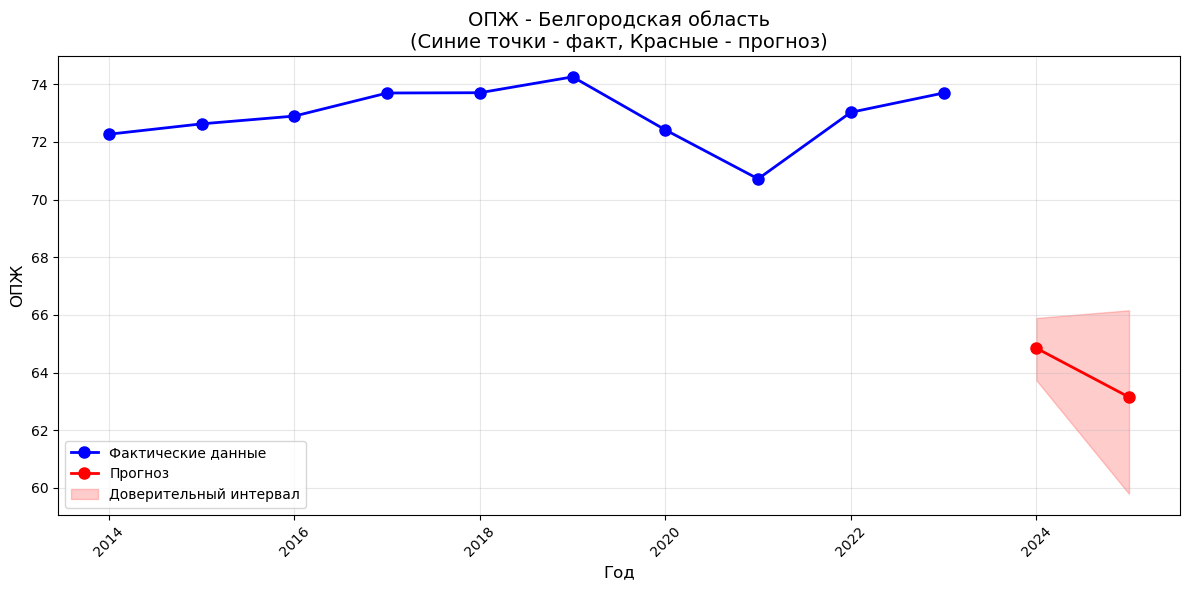


=== АНАЛИЗ ОПЖ - Брянская область ===
Фактические данные:
  2014: 69.37
  2015: 70.30
  2016: 70.84
  2017: 71.16
  2018: 71.57
  2019: 72.14
  2020: 70.48
  2021: 68.54
  2022: 71.22
  2023: 71.98
Прогноз на будущее:
  2024: 65.55
  2025: 63.61


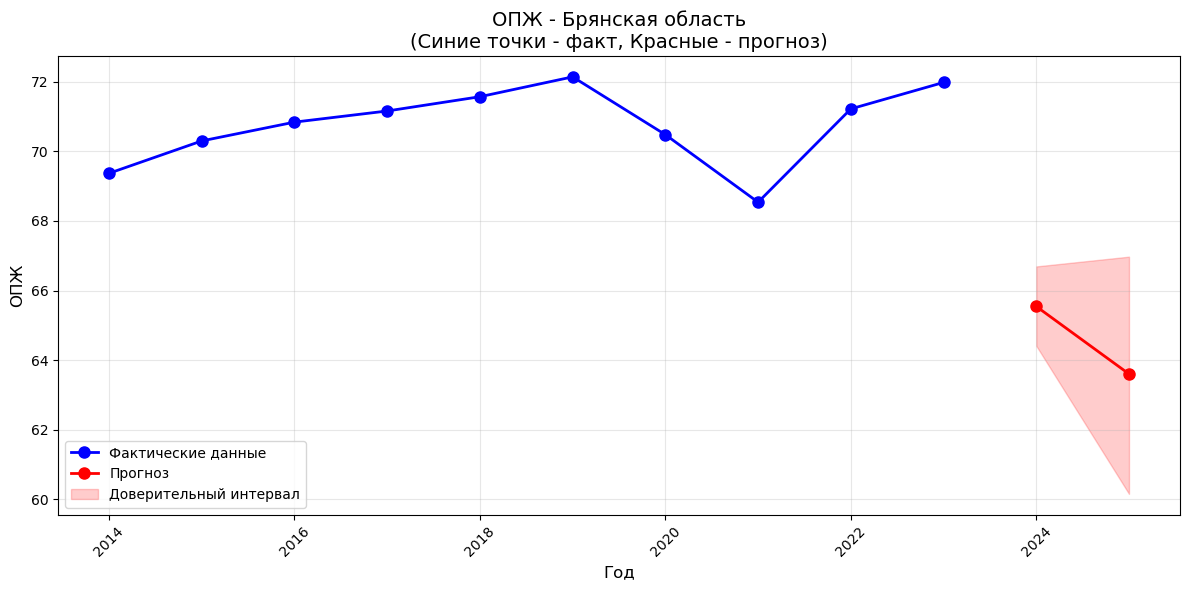


=== АНАЛИЗ ОПЖ - Владимирская область ===
Фактические данные:
  2014: 69.30
  2015: 69.88
  2016: 70.36
  2017: 71.25
  2018: 71.35
  2019: 72.00
  2020: 70.19
  2021: 68.31
  2022: 70.80
  2023: 71.62
Прогноз на будущее:
  2024: 61.73
  2025: 59.85


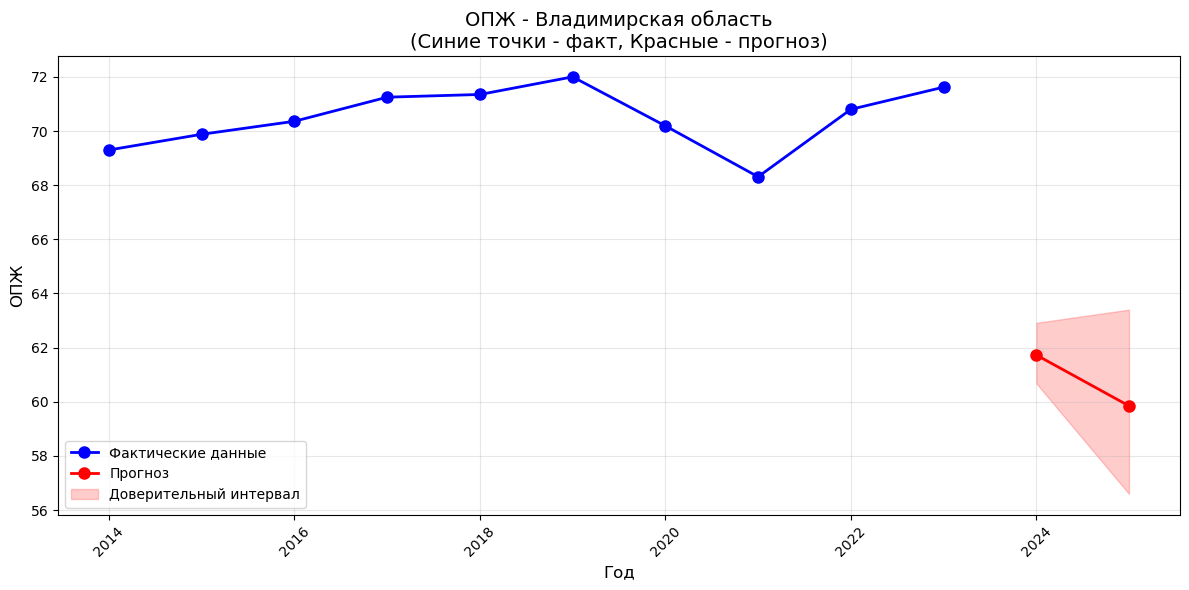


=== АНАЛИЗ ОПЖ - Воронежская область ===
Фактические данные:
  2014: 70.82
  2015: 71.67
  2016: 72.08
  2017: 73.03
  2018: 73.15
  2019: 73.61
  2020: 71.94
  2021: 69.58
  2022: 72.45
  2023: 72.91
Прогноз на будущее:
  2024: 64.11
  2025: 61.75


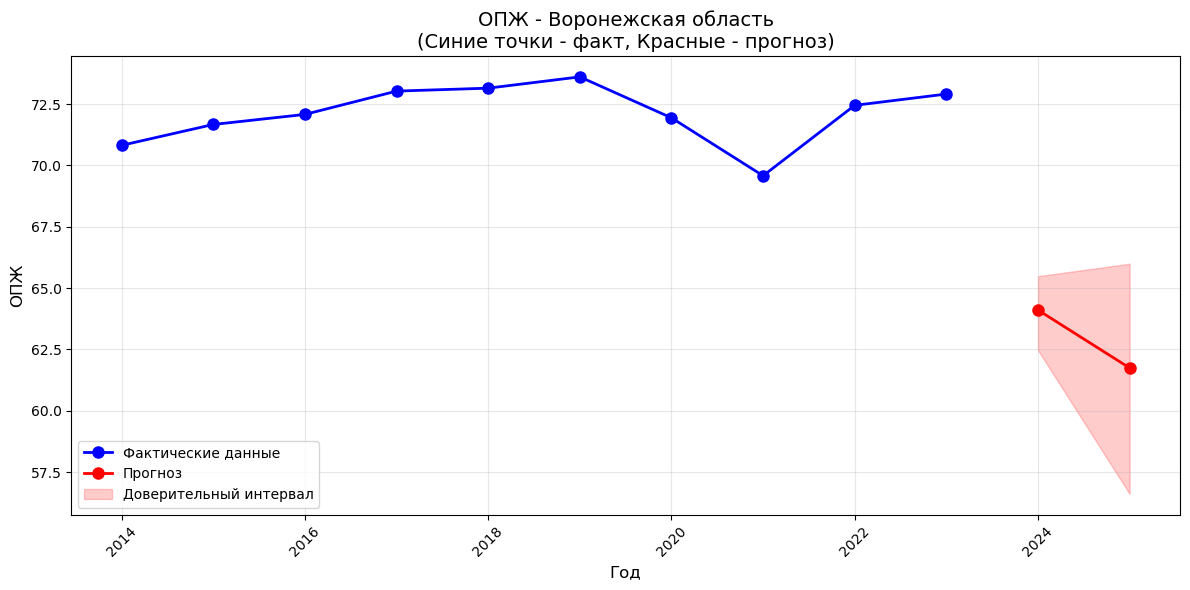


=== АНАЛИЗ ОПЖ - Ивановская область ===
Фактические данные:
  2014: 69.70
  2015: 70.40
  2016: 70.50
  2017: 71.16
  2018: 70.92
  2019: 71.41
  2020: 70.18
  2021: 68.51
  2022: 70.57
  2023: 71.18
Прогноз на будущее:
  2024: 63.19
  2025: 61.52


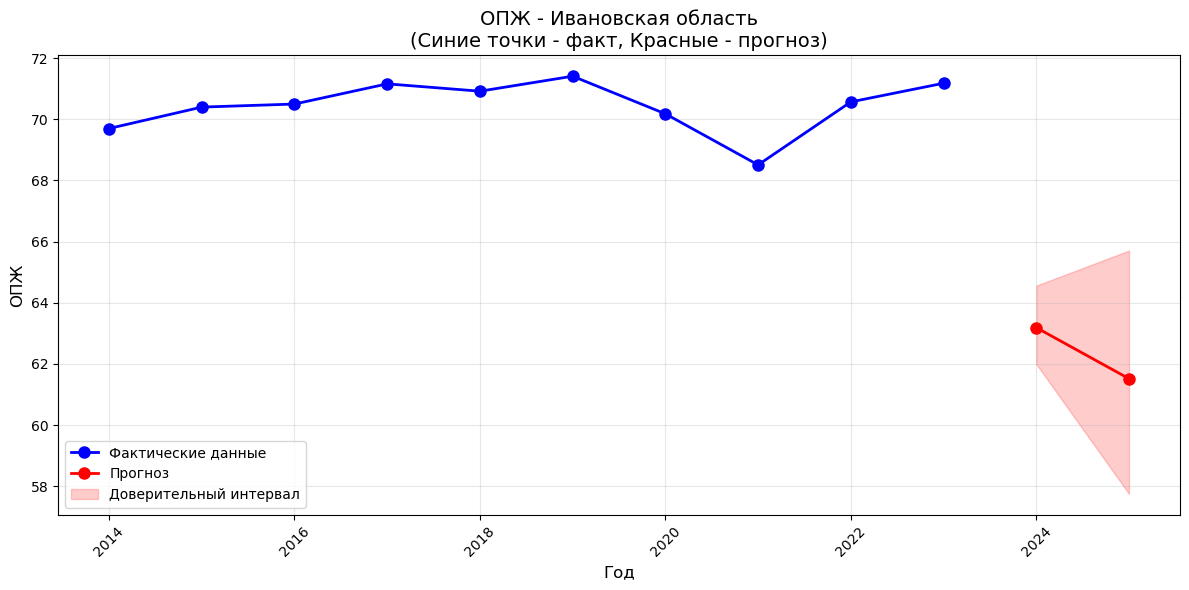


=== АНАЛИЗ СКР - Белгородская область ===
Фактические данные:
  2014: 1.54
  2015: 1.56
  2016: 1.55
  2017: 1.39
  2018: 1.36
  2019: 1.29
  2020: 1.24
  2021: 1.27
  2022: 1.17
  2023: 1.12
Прогноз на будущее:
  2024: 1.07
  2025: 1.00


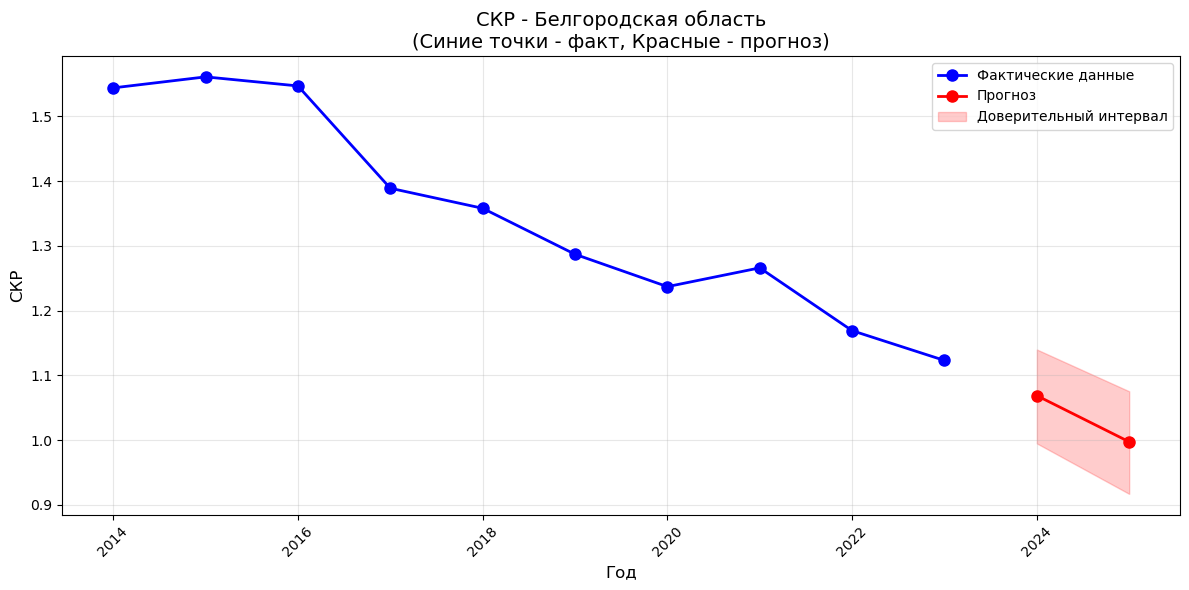


=== АНАЛИЗ СКР - Брянская область ===
Фактические данные:
  2014: 1.55
  2015: 1.65
  2016: 1.61
  2017: 1.43
  2018: 1.43
  2019: 1.32
  2020: 1.31
  2021: 1.28
  2022: 1.20
  2023: 1.19
Прогноз на будущее:
  2024: 1.13
  2025: 1.02


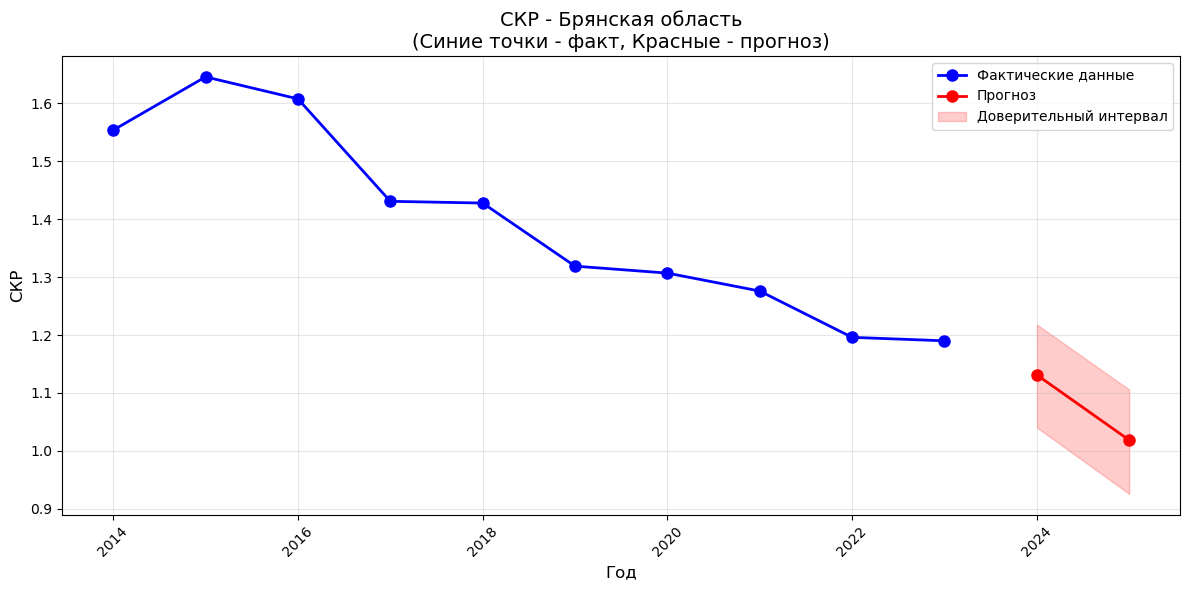


=== АНАЛИЗ СКР - Владимирская область ===
Фактические данные:
  2014: 1.62
  2015: 1.71
  2016: 1.68
  2017: 1.49
  2018: 1.46
  2019: 1.32
  2020: 1.24
  2021: 1.25
  2022: 1.16
  2023: 1.15
Прогноз на будущее:
  2024: 1.02
  2025: 0.91


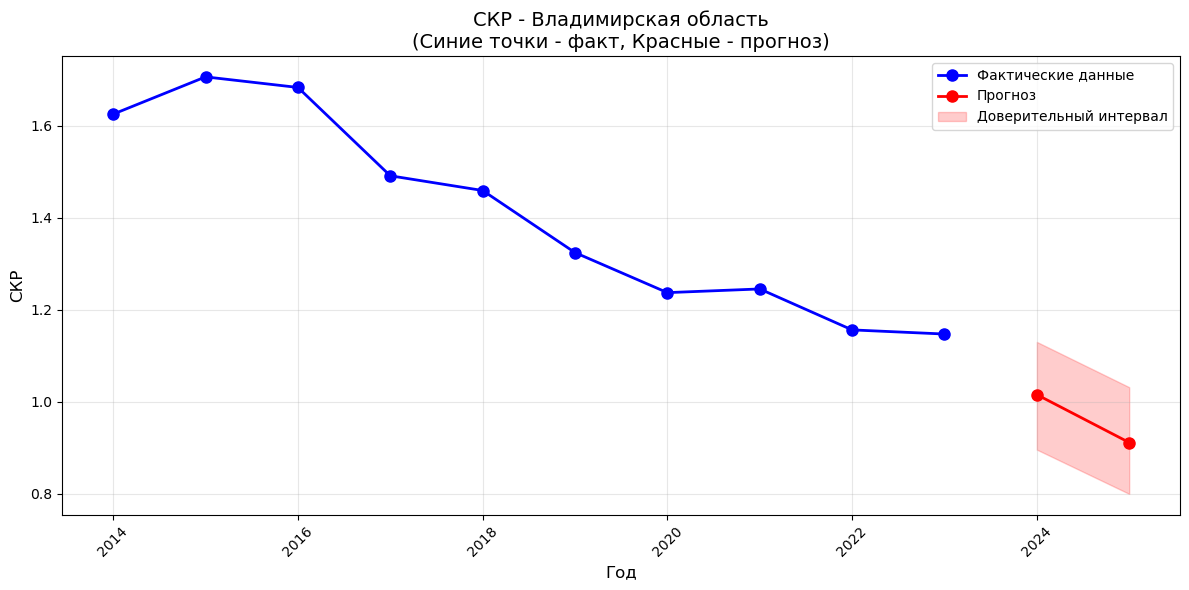


=== АНАЛИЗ СКР - Воронежская область ===
Фактические данные:
  2014: 1.47
  2015: 1.51
  2016: 1.48
  2017: 1.36
  2018: 1.33
  2019: 1.26
  2020: 1.26
  2021: 1.27
  2022: 1.23
  2023: 1.22
Прогноз на будущее:
  2024: 1.13
  2025: 1.06


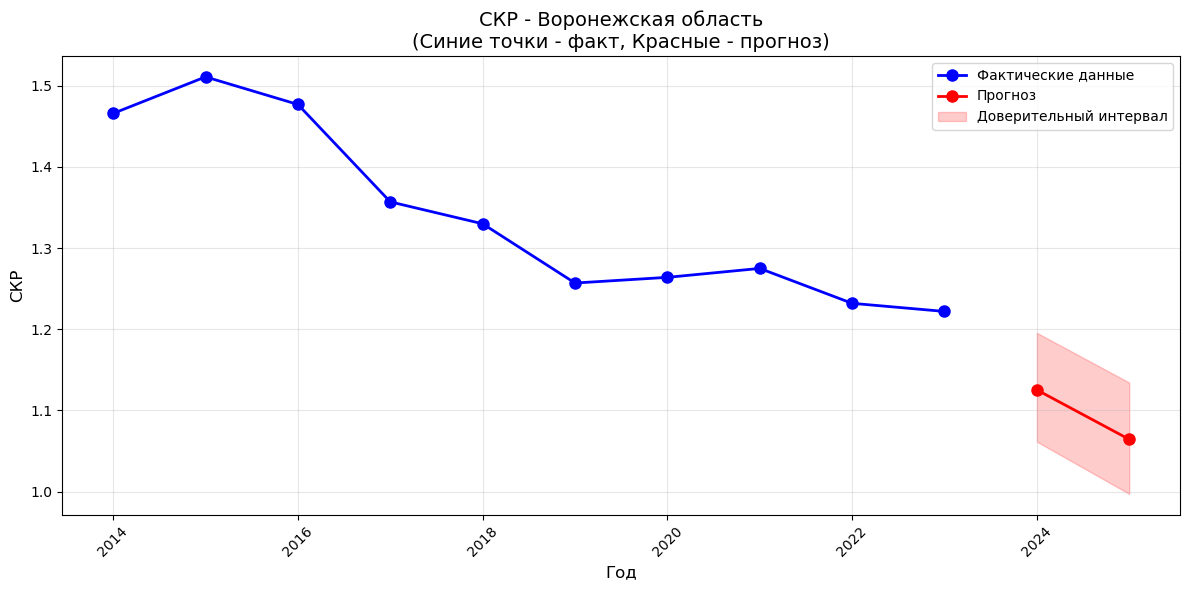


=== АНАЛИЗ СКР - Ивановская область ===
Фактические данные:
  2014: 1.60
  2015: 1.68
  2016: 1.66
  2017: 1.54
  2018: 1.50
  2019: 1.37
  2020: 1.35
  2021: 1.40
  2022: 1.37
  2023: 1.35
Прогноз на будущее:
  2024: 1.20
  2025: 1.15


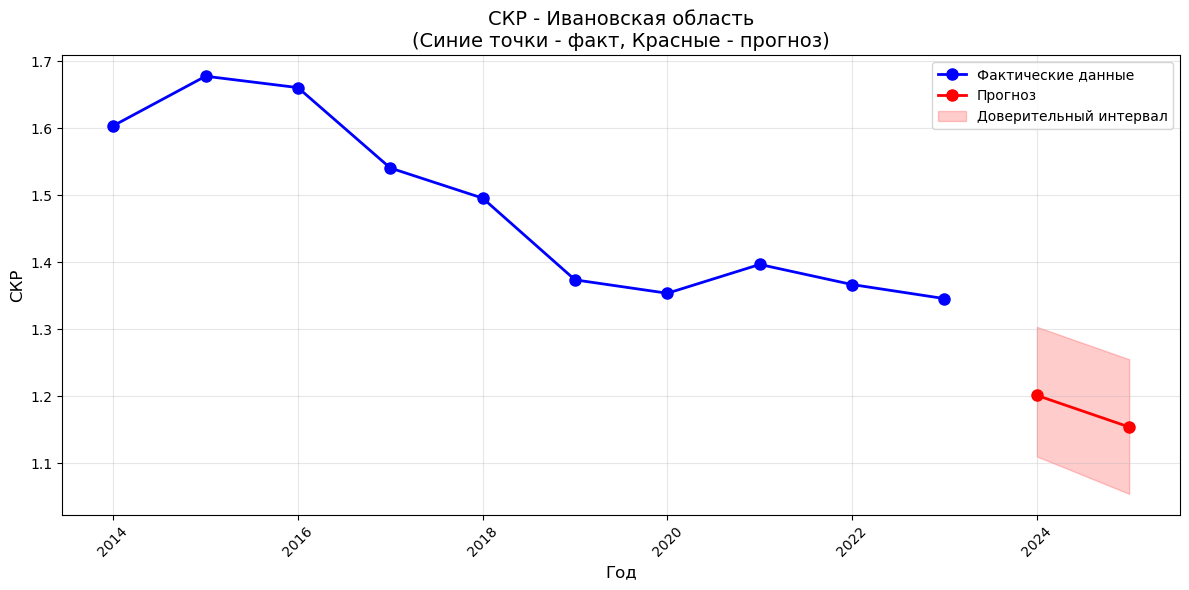

In [13]:
# Сначала проверим данные
print("=== ПРОВЕРКА ДАННЫХ ===")
print("df_opzh_clean columns:", df_opzh_clean.columns.tolist())
print("df_skr_clean columns:", df_skr_clean.columns.tolist())

# подготовка данных
df_opzh_prophet = prepare_data_for_prophet(df_opzh_clean, 'ОПЖ')
df_skr_prophet = prepare_data_for_prophet(df_skr_clean, 'СКР')

print("После подготовки:")
print("df_opzh_prophet sample:")
print(df_opzh_prophet.head())
print("\ndf_skr_prophet sample:")
print(df_skr_prophet.head())

# Обучение улучшенными моделями
print("\n=== ОБУЧЕНИЕ УЛУЧШЕННЫХ МОДЕЛЕЙ ===")
models_opzh, forecasts_opzh, metrics_opzh = train_prophet_models(df_opzh_prophet)
models_skr, forecasts_skr, metrics_skr = train_prophet_models(df_skr_prophet)

# Визуализация
print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")
for region in list(models_opzh.keys())[:5]:  # Первые 5 регионов
    plot_forecasts(forecasts_opzh, df_opzh_prophet, 'ОПЖ', region, models_opzh)

for region in list(models_skr.keys())[:5]:
    plot_forecasts(forecasts_skr, df_skr_prophet, 'СКР', region, models_skr)

In [14]:
# === Сохранение финальных предсказаний ===

def save_final_predictions(forecasts_dict, original_df, target_name, output_file):
    """
    forecasts_dict: словарь {регион: прогноз от Prophet}
    original_df: исходный df с реальными годами (нужен для последнего года)
    target_name: 'ОПЖ' или 'СКР'
    """
    results = []
    
    for region, forecast in forecasts_dict.items():
        # прогноз от Prophet — уже содержит 'ds' и 'yhat'
        for _, row in forecast.iterrows():
            year = row['ds'].year
            pred = row['yhat']
            results.append({
                'Регион': region,
                'Год': year,
                target_name: None,  # в тесте нет реального значения → ставим None
                'predictions': pred
            })
    
    result_df = pd.DataFrame(results)
    result_df.to_excel(output_file, index=False)
    print(f"Сохранено: {output_file} ({len(result_df)} строк)")

# Сохраняем
save_final_predictions(forecasts_opzh, df_opzh_prophet, 'ОПЖ', 'predictions_opzh.xlsx')
save_final_predictions(forecasts_skr, df_skr_prophet, 'СКР', 'predictions_skr.xlsx')

Сохранено: predictions_opzh.xlsx (170 строк)
Сохранено: predictions_skr.xlsx (170 строк)
